In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import jit
import scipy.optimize as spopt
from scipy.optimize import curve_fit

In [2]:
# set the events with the corresponding rates
@numba.jit(nopython=True)

def propensities(state,c,methylation,activation,N,
                delta_f=-2,Ki=18,Ka=2900,kR=0.1,kB=0.2,kAct=50):
    # arrays to store results
    rates = np.zeros(2)
    events = np.zeros((2,2))

    # calculate free-energy difference
    mbase = N/2
    f = N*np.log((1 + c/Ki)/(1 + c/Ka)) + delta_f*(state[1] - mbase)

    # set rate constants for (de)activation
    kDeact = kAct*np.exp(f)

    # check methylation states
    mMax = 4*N
    meth_ceiling = state[1] < mMax
    meth_floor = state[1] > 0

    # for inactive cluster
    if state[0] == 0:
        # methylation; only possible if a site is available
        rates[0] = kR*meth_ceiling*methylation
        events[0] = [0,1]

        # activity switching
        rates[1] = kAct*activation
        events[1] = [1,0]

    # for active cluster
    else:
        # demethylation; only possible if a site is occupied
        rates[0] = kB*meth_floor*methylation
        events[0] = [0,-1]

        # deactivation
        rates[1] = kDeact*activation
        events[1] = [-1,0]
        
    return rates, events

@numba.jit(nopython=True)

def gillespie_nolig(a0,m0,tf,n_steps,n_sims,step_change,cnew,
                    Nr=6,methylation=True,activation=True,cbase=100):
    # set up arrays to hold the results
    t_grid = np.linspace(0,tf,n_steps+1)
    all_states = np.zeros((n_sims,n_steps+1,2))
    
    # set initial state
    all_states[:,0,0] = a0
    all_states[:,0,1] = m0
    
    ############# actual algorithm #############
    
    for i in range(n_sims):
        # initialise each realisation
        state = np.array([a0, m0])
        dt = 0
        time = 0
        
        # loop over all time steps
        for j in range(n_steps):
            # change concentration after step_change time steps
            if j >= step_change:
                c = cnew
            else:
                c = cbase
                
            # ensure initialisation; not necessary after initial round
            if time == 0:
                # set state to extract rates and propensities
                rates, events = propensities(state,c,methylation,activation,Nr)

                # determine which event occurs
                p = np.random.uniform(0,1)*np.sum(rates)
                mask = p < np.cumsum(rates)
                event_idx = np.where(mask == True)[0][0]

                # this samples the time until the next event
                u = np.random.uniform(0,1)
                dt = -np.log(u)/np.sum(rates)
                time += dt
                
            # keep updating until we reach the end of the interval
            while time < t_grid[j]:                
                # extract rates and propensities for next round
                state = state + events[event_idx]
                rates, events = propensities(state,c,methylation,activation,Nr)

                # determine which event occurs
                p = np.random.uniform(0,1)*np.sum(rates)
                mask = p < np.cumsum(rates)
                event_idx = np.where(mask == True)[0][0]

                # this samples the time until the next event
                u = np.random.uniform(0,1)
                dt = -np.log(u)/np.sum(rates)
                time += dt
                
            # save the last state before passing the boundary
            all_states[i,j+1,:] = state
            
    ############ averaging ############
    
    av_states = np.zeros((n_steps+1,2))
    av_states[0,0] = a0
    av_states[0,1] = m0
    
    # averaging in the awkward numba way
    for j in range(n_steps):
        for k in range(2):
            av_states[j+1,k] = np.mean(all_states[:,j+1,k])
            
    # normalise
    mMax = 4*Nr
    av_states[:,1] = av_states[:,1]/mMax
            
    return av_states, t_grid

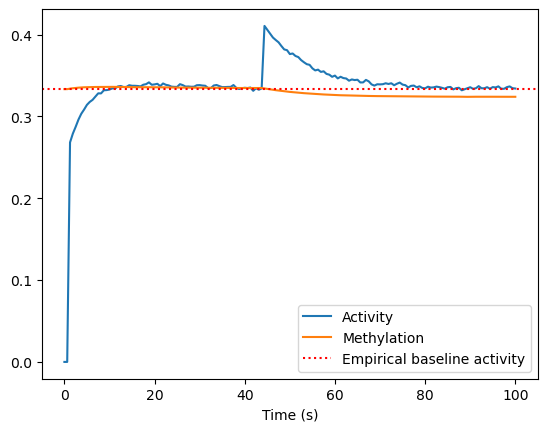

In [3]:
# check that the algorithm works
a0 = 0.
m0 = 8.
tf = 100
n_steps = 160
n_sims = 10**5
step_change = 70
cnew = 90

results, time = gillespie_nolig(a0,m0,tf,n_steps,n_sims,step_change,cnew,methylation=True)

plt.plot(time,results[:,0],label='Activity')
plt.plot(time,results[:,1],label='Methylation')
plt.axhline(y=1/3,xmin=0,xmax=1,linestyle=':',color='r',label='Empirical baseline activity')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

In [4]:
# check how fast the algorithm is
a0 = 0.
m0 = 8.
tf = 100
n_steps = 160
n_sims = 10**2
step_change = 70
cnew = 80

%timeit gillespie_nolig(a0,m0,tf,n_steps,n_sims,step_change,cnew,methylation=True)

291 ms ± 12.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Running the algortihm $10^4$ under these conditions would take about 30 s.  

## Dose-response curve

In this section, we use the simulation to extract the dose-response curve. The procedure is as follows. We turn methylation off to prevent adaptation. After equilibration, the cluster receives a step increase in concentration, upon which the activity settles to a new equilibrium. We measure the amplitude of the response as the difference between the activity just before the change in concentration and the new equilibrium activity, which we take from the last point of the simulation. Repeating this procedure for various values of the final concentration allows us to extract a dose-response curve. 

The aim here is not to replicate any measured dose-response curve. Instead, the aim is to reproduce some qualitative characteristics of a typical dose-response curve extracted from an MWC model, such as its sigmoidal shape. This would provide evidence that our model agrees with the non-dynamical MWC model.

In [7]:
# define a function that finds the response for an array of concentration
@numba.jit(nopython=True)

def response_finder(cnew_arr,a0=0.,m0=8.,tf=60,n_steps=200,n_sims=10**3):
    # set when the concentration is changed
    step_change = int(np.floor(0.4*n_steps))
    
    # array to store results
    all_responses = np.zeros(cnew_arr.size)
    
    # loop for various new concentrations
    for i, cnew in enumerate(cnew_arr):
        # obtain activity and time
        results,_ = gillespie_nolig(a0,m0,tf,n_steps,n_sims,step_change,cnew,methylation=False)
        activity = results[:,0]
        
        # set baseline and extract new equilibrium
        baseline = activity[step_change-1]
        new_act = activity[-1]
        
        # save response
        all_responses[i] = new_act - baseline
     
    return all_responses

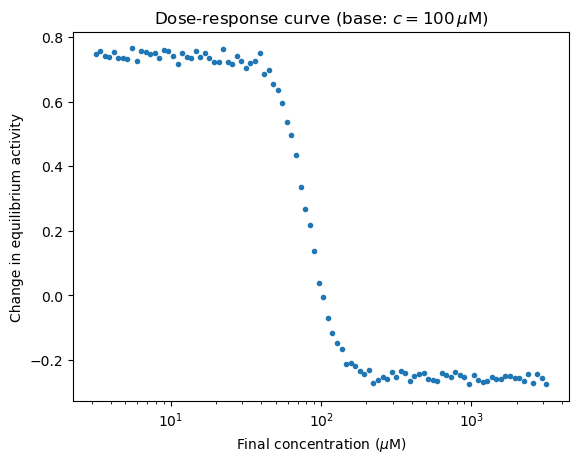

In [8]:
# find responses
cnew_arr = np.logspace(0.5,3.5,100)
responses = response_finder(cnew_arr)

# show results
plt.semilogx(cnew_arr,responses,'.')
plt.xlabel(r'Final concentration ($\mu$M)')
plt.ylabel('Change in equilibrium activity')
plt.title(r'Dose-response curve (base: $c=100\, \mu$M)')
plt.show()

## Fitting to Extract Response and Adaptation Timescale

This part uses a model proposed by Mattingly et al. (2021) for the shape of the response curve as

$$ K(t) = G \exp\{-t/\tau_2\}(1 - \exp\{-t/\tau_1\})H(t), $$

where $K(t)$ is the response, $G$ is the gain or amplitude, $\tau_1$ is the rise time, $\tau_2$ is the adaptation time and $H(t)$ is the Heaviside step function. Note that we have subtracted the baseline activity and set $t=0$ when the concentration is increased. Furthermore, Mattingly et al. only probed responses for a 10% increase or decrease in concentration, starting from a background of 100 $\mu$M.

Additionally, this model is fitted to a rescaled version of the activity. Concretely, $K(t)$ is fitted to $a(t)/\log(c_0/c_f)$, where $c_f = 90 \, \mu$M is the final concentration and $c_0 = 100\,\mu$M is the baseline concentration.   

Ultimately, the aim of this section is to compare our fitting results to those of Mattingly et al. They find $G = 1.73 \pm 0.03$, $\tau_1 = 0.22 \pm 0.01$ s and $\tau_2 = 9.90 \pm 0.30$ s, so we would like to verify to what extent our simulations reproduce these features of their experiment.

Parameters of best fit: [G, tau1, tau2] = [ 0.73102662  0.17025477 11.2018325 ]
Covariances: [[ 9.54909520e-05  6.31842682e-05 -1.45503030e-03]
 [ 6.31842682e-05  3.28675413e-04 -9.35035588e-04]
 [-1.45503030e-03 -9.35035588e-04  4.00792291e-02]]
Standard deviations: [0.009771947198138137, 0.01812940741543746, 0.2001979746577671]


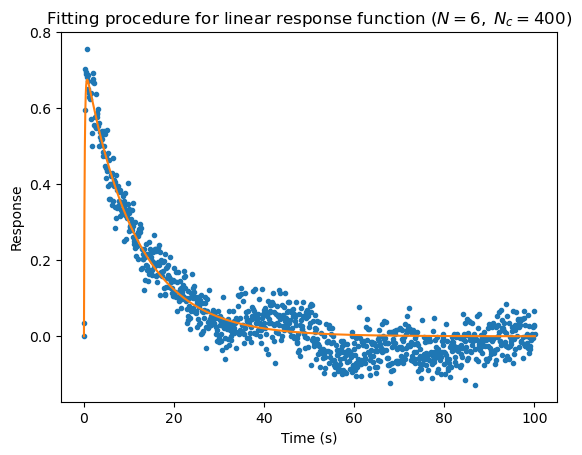

In [4]:
# obtain nice data
a0 = 0.
m0 = 8.
tf = 400
n_steps = 4000
n_sims = 10**4
step_change = 3000
cnew = 90

results, time = gillespie_nolig(a0,m0,tf,n_steps,n_sims,step_change,cnew)

# find response
activity = results[:,0]
shifted_activity = activity[step_change-1:] - activity[step_change-1]
response = shifted_activity/np.log(100/cnew)

shifted_time = time[step_change-1:] - time[step_change-1]

# define model function
def mattingly_fit(t,G,tau1,tau2):
    return G*np.exp(-t/tau2)*(1 - np.exp(-t/tau1))

# perform fitting
popt_lit, pcov_lit = curve_fit(mattingly_fit,shifted_time,response)
print('Parameters of best fit: [G, tau1, tau2] =',popt_lit)
print('Covariances:', pcov_lit)
print('Standard deviations:', [np.sqrt(pcov_lit[i,i]) for i in range(3)])

# show results
plt.plot(shifted_time,response,'.',label='Simulation')
plt.plot(shifted_time, mattingly_fit(shifted_time, *popt_lit),label='Fit')
plt.xlabel('Time (s)')
plt.ylabel('Response')
plt.title(r'Fitting procedure for linear response function ($N=6, \; N_c = 400$)')
plt.show()

### Interpretation

Our fit indicates time scales $\tau_1$ and $\tau_2$ for response and adaptation, respectively, similar to those found by Mattingly and colleagues. However, our estimate of $G$ is an order of magnitude lower than their experiments suggest. This aligns with Manuel's findings. Together, this indicates that our dynamical MWC does not reproduce the experiments by Mattingly et al. well, given the parameter values that are often used in the literature. Therefore, we assess whether changing the number of receptors per cluster ($N$) and number of clusters ($N_c$) removes the discrepancy between our simulations and their experiments. Concretely, we follow Manuel's suggestion to change $N$ from 6 to 15 and $N_c$ from 400 to 9. Note that while $N_c$ does not affect the procedure for finding $K(t)$, it does have a strong effect on the noise kernel (see below).

Parameters of best fit: [G, tau1, tau2] = [ 1.91749782  0.14692117 12.35134037]
Covariances: [[ 1.98185235e-04  4.38695565e-05 -1.27205922e-03]
 [ 4.38695565e-05  9.57167964e-05 -2.74934284e-04]
 [-1.27205922e-03 -2.74934284e-04  1.50545174e-02]]
Standard deviations: [0.014077827790307846, 0.009783496122852592, 0.122696851478898]


/tmp/ipykernel_7698/2929743944.py:21: RuntimeWarning: overflow encountered in exp
  return G*np.exp(-t/tau2)*(1 - np.exp(-t/tau1))


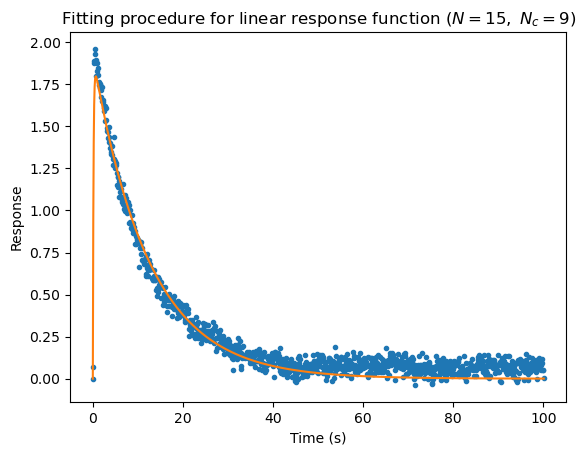

In [5]:
# obtain nice data
a0 = 0.
m0 = 8.
tf = 400
n_steps = 4000
n_sims = 10**4
step_change = 3000
cnew = 90

results, time = gillespie_nolig(a0,m0,tf,n_steps,n_sims,step_change,cnew,Nr=15)

# find response
activity = results[:,0]
shifted_activity = activity[step_change-1:] - activity[step_change-1]
response = shifted_activity/np.log(100/cnew)

shifted_time = time[step_change-1:] - time[step_change-1]

# perform fitting
popt_adj, pcov_adj = curve_fit(mattingly_fit,shifted_time,response)
print('Parameters of best fit: [G, tau1, tau2] =',popt_adj)
print('Covariances:', pcov_adj)
print('Standard deviations:', [np.sqrt(pcov_adj[i,i]) for i in range(3)])

# show results
plt.plot(shifted_time,response,'.',label='Simulation')
plt.plot(shifted_time, mattingly_fit(shifted_time, *popt_adj),label='Fit')
plt.xlabel('Time (s)')
plt.ylabel('Response')
plt.title(r'Fitting procedure for linear response function ($N=15, \; N_c = 9$)')
plt.show()

### Interpretation

The fitted values for $N=15$ and $N_c = 9$ are in much better agreement with the experimental results by Mattingly et al., with $G$ in particular. For convenience, we show both the simulated fits as well as the fit obtained by Mattingly et al. in the plot below.

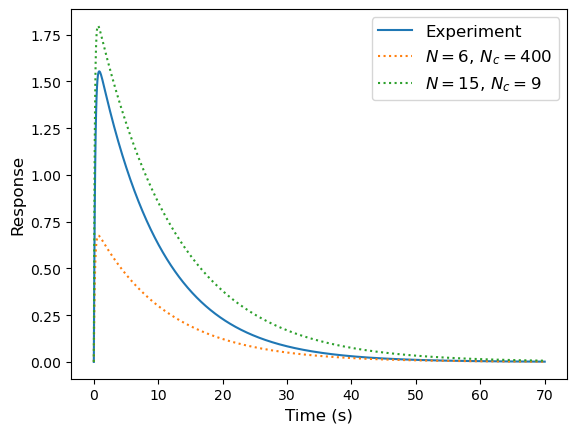

In [13]:
# some time grid
t_grid = np.linspace(0,70,10**3)

plt.plot(t_grid,mattingly_fit(t_grid,1.73,0.22,9.90),label='Experiment')
plt.plot(t_grid,mattingly_fit(t_grid,*popt_lit),':',label=r'$N = 6,\, N_c = 400$')
plt.plot(t_grid,mattingly_fit(t_grid,*popt_adj),':',label=r'$N = 15,\, N_c = 9$')

plt.xlabel('Time (s)',size=12)
plt.ylabel('Response',size=12)
plt.legend(fontsize=12)
plt.show()

## Noise kernel

Here we estimate the noise kernel in order to compare our results to Mattingly et al.'s work. The aim is to find the autocorrelator, which we do as follows. Firstly, we simulate a trajectory $a_i(t)$ on the cell level, meaning that it is averaged over $N_c = 400$ clusters. Since we are interested in the steady-state noise, the background concentration is kept constant at $c = 100\,\mu$M and the transient until reaching equilibrium is cut off. We repeat this procedure $N_s$ times to obtain the activities $a_1(t),...,a_{N_s}(t)$. The noise kernel is then defined as the autocorrelation of the activity with itself,

$$ N(t) \equiv \langle a(t)a(0) \rangle - \langle a(t) \rangle \langle a(0) \rangle, $$

with $t=0$ where the transient is cut off. Computing $N(t)$ thus requires taking ensemble averages over the sets $\{ a_1(t), ..., a_{N_s}(t)\}$, $\{a_1(0),...,a_{N_s}(0) \}$ and $\{a_1(t)a_1(0),...,a_{N_s}(t)a_{N_s}(0) \}$.

Measurements indicate that $x(t)$ is well approximated by an Ornstein-Uhlenbeck process, such that the noise kernel is of the form

$$ N(t) = \sigma_n^2 \exp\{-|t|/\tau_n\}, $$

where $\sigma_n$ sets the amplitude and $\tau_n$ the time scale of the fluctuations in $x(t)$. From their measurements, Mattingly et al. find that $\sigma_n = 0.092 \pm 0.002$ and $\tau_n = 11.75 \pm 0.04$ s, so the aim of this section is to check whether our simulations agree with these values.

In [84]:
@numba.jit(nopython=True)

# function for finding several realisations of single-cell activity
def activity_finder(n_steps,tf,n_samples,N,Nc,a0=0.,m0=8.):
    # array to save results
    all_act = np.zeros((n_steps+1,n_samples))
    
    for sample in range(n_samples):
        # obtain a realisation
        results, time = gillespie_nolig(a0,m0,tf,n_steps,Nc,100,100)
        
        # store only the activity
        all_act[:,sample] = results[:,0]
        
    return all_act, time

# function for finding autocorrelator of a time series; not in Numba mode!
def autocorr(all_act,time,co):
    # obtain average of product
    ata0_av = np.mean(all_act[co:,:]*all_act[co,:],axis=1)
    
    # obtain factors for product of averages
    at_av = np.mean(all_act[co:,:],axis=1)
    a0_av = np.mean(all_act[co,:])
    
    # shift time
    time_s = time[co:] - time[co]
    
    # return the autocorrelator: average of product minus product of averages
    return ata0_av-at_av*a0_av, time_s

In [136]:
# set parameters
n_steps = 100
tf = 60
n_samples = 250

# receptor parameters
N = 6
Nc = 12

# obtain activities
all_act, time = activity_finder(n_steps,tf,n_samples,N,Nc)

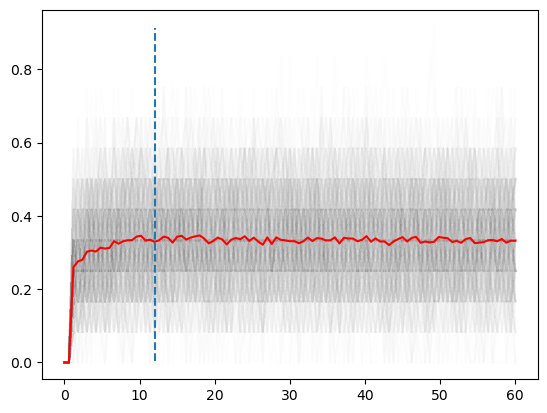

Time: [ 0.   0.6  1.2  1.8  2.4  3.   3.6  4.2  4.8  5.4  6.   6.6  7.2  7.8
  8.4  9.   9.6 10.2 10.8 11.4 12.  12.6 13.2 13.8 14.4 15.  15.6 16.2
 16.8 17.4 18.  18.6 19.2 19.8 20.4 21.  21.6 22.2 22.8 23.4 24.  24.6
 25.2 25.8 26.4 27.  27.6 28.2 28.8 29.4 30.  30.6 31.2 31.8 32.4 33.
 33.6 34.2 34.8 35.4 36.  36.6 37.2 37.8 38.4 39.  39.6 40.2 40.8 41.4
 42.  42.6 43.2 43.8 44.4 45.  45.6 46.2 46.8 47.4 48.  48.6 49.2 49.8
 50.4 51.  51.6 52.2 52.8 53.4 54.  54.6 55.2 55.8 56.4 57.  57.6 58.2
 58.8 59.4 60. ]
Time at cutoff: 12.0
Shifted time: [ 0.   0.6  1.2  1.8  2.4  3.   3.6  4.2  4.8  5.4  6.   6.6  7.2  7.8
  8.4  9.   9.6 10.2 10.8 11.4 12.  12.6 13.2 13.8 14.4 15.  15.6 16.2
 16.8 17.4 18.  18.6 19.2 19.8 20.4 21.  21.6 22.2 22.8 23.4 24.  24.6
 25.2 25.8 26.4 27.  27.6 28.2 28.8 29.4 30.  30.6 31.2 31.8 32.4 33.
 33.6 34.2 34.8 35.4 36.  36.6 37.2 37.8 38.4 39.  39.6 40.2 40.8 41.4
 42.  42.6 43.2 43.8 44.4 45.  45.6 46.2 46.8 47.4 48. ]
Av. activity: [0.         0.       

In [137]:
co = 20

for ff in range(n_samples):
    plt.plot(time,all_act[:,ff],color='grey',alpha=0.01)
    
plt.plot(time,np.mean(all_act,axis=1),color='red')
plt.axvline(x=time[co],ymin=0.05,ymax=0.95,ls='--')
plt.show()

# show truncated trajectory

print('Time:',time)
print('Time at cutoff:',time[co])
print('Shifted time:',time[co:] - time[co])

print('Av. activity:', np.mean(all_act,axis=1))
print('Av. activity at cutoff:', np.mean(all_act[co,:]))
print('Av. cut off activity:',np.mean(all_act[co:,:],axis=1))
print('Product of averages:',np.mean(all_act[co,:])*np.mean(all_act[co:,:],axis=1))
print('Product of medians:',np.median(all_act[co,:])*np.median(all_act[co:,:],axis=1))
print('Average of product:', np.mean(all_act[co:,:]*all_act[co,:],axis=1))
print('Autocorrelation:',np.mean(all_act[co:,:]*all_act[co,:],axis=1)-np.mean(all_act[co,:])*np.mean(all_act[co:,:],axis=1))

In [138]:
np.median(all_act[co+6,:])

all_act[co+6,:]

array([0.58333333, 0.41666667, 0.33333333, 0.25      , 0.33333333,
       0.33333333, 0.25      , 0.25      , 0.5       , 0.25      ,
       0.5       , 0.16666667, 0.41666667, 0.33333333, 0.41666667,
       0.25      , 0.25      , 0.25      , 0.33333333, 0.16666667,
       0.25      , 0.5       , 0.5       , 0.41666667, 0.58333333,
       0.16666667, 0.33333333, 0.33333333, 0.58333333, 0.25      ,
       0.16666667, 0.5       , 0.41666667, 0.08333333, 0.5       ,
       0.41666667, 0.16666667, 0.25      , 0.16666667, 0.58333333,
       0.41666667, 0.41666667, 0.08333333, 0.33333333, 0.41666667,
       0.08333333, 0.16666667, 0.33333333, 0.33333333, 0.25      ,
       0.58333333, 0.41666667, 0.58333333, 0.25      , 0.08333333,
       0.16666667, 0.25      , 0.5       , 0.58333333, 0.41666667,
       0.33333333, 0.5       , 0.41666667, 0.41666667, 0.41666667,
       0.33333333, 0.25      , 0.33333333, 0.33333333, 0.33333333,
       0.33333333, 0.33333333, 0.41666667, 0.41666667, 0.41666

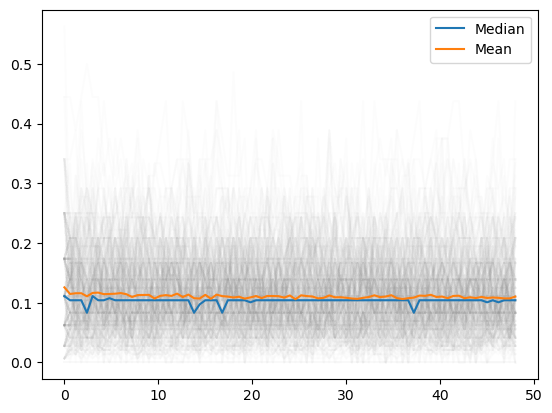

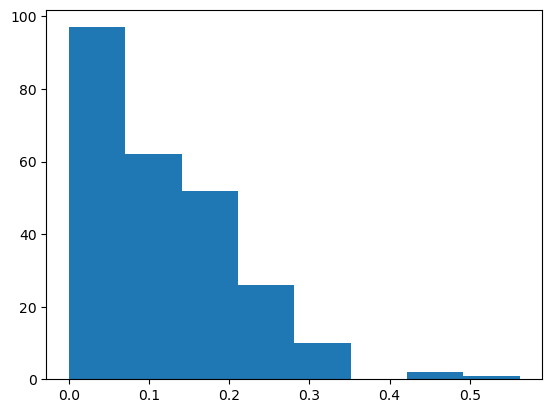

In [139]:
all_prod = all_act[co:,:]*all_act[co,:]
time_s = time[co:] - time[co]

for ff in range(n_samples):
    plt.plot(time_s,all_prod[:,ff],color='grey',alpha=0.02)
    
plt.plot(time_s,np.median(all_prod,axis=1),label='Median')
plt.plot(time_s,np.mean(all_prod,axis=1),label='Mean')
plt.legend()
plt.show()

plt.hist(all_prod[0,:],bins=8)
plt.show()

0.0005418783999999999
0.0005418783999999871
Parameters of best fit: [sigma, tau_n] = [0.01725211 3.26966662]
Standard deviations: [0.0006409637223948364, 0.35944193521577966]


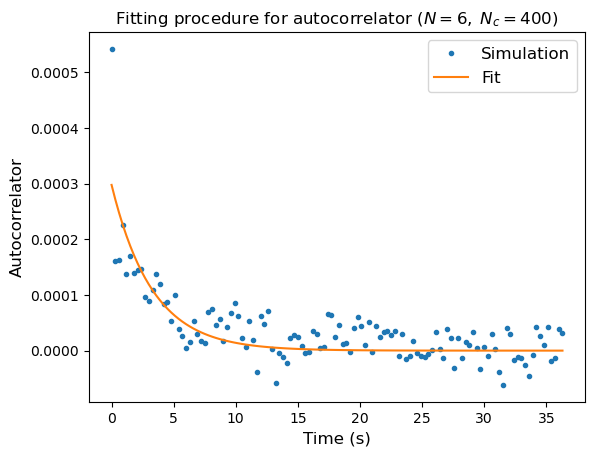

In [81]:
# set parameters
n_steps = 200
tf = 60
n_samples = 250

# receptor parameters
N = 6
Nc = 400

# obtain activities
all_act, time = activity_finder(n_steps,tf,n_samples,N,Nc)

# set cut-off
co = 80

# compute autocorrelator
auto_corr, time_s = autocorr(all_act,time,co)

# define model function
def noise_fit(t,sigma,taun):
    return sigma**2*np.exp(-np.abs(t)/taun)

# perform fitting
popt_nlit, pcov_nlit = curve_fit(noise_fit,time_s,auto_corr)

print('Parameters of best fit: [sigma, tau_n] =', popt_nlit)
print('Standard deviations:', [np.sqrt(pcov_nlit[i,i]) for i in range(2)])

# show results
plt.plot(time_s,auto_corr,'.',label='Simulation')
plt.plot(time_s,noise_fit(time_s,*popt_nlit),label='Fit')
plt.xlabel('Time (s)',size=12)
plt.ylabel('Autocorrelator',size=12)
plt.title(r'Fitting procedure for autocorrelator ($N=6, \; N_c = 400$)')
plt.legend(fontsize=12)
plt.show()

**Problem:** the first point in the autocorrelator is much higher and sometimes messes up the fit. What to do? I tried doing a log-transform to make the fitting less sensitive to outliers, but then I must delete negative data points. I think the problem is that the average of the product is sensitive to outliers, since the baseline activity is around 1/3, so the simulation has more 'space' to shoot over than under this baseline. As a result, the overshoots are not averaged out as well, making the mean more sensitive to outliers. Is it then justified to take the median instead? Should check whether that works alright...

### Interpretation

From our fitting procedure, we consistently find values of $\sigma_n$ that are roughly a factor of 10 below Mattingly et al.'s estimate. This agrees with Manuel's findings. Evidently, the dynamic MWC model does not reproduce the data by Mattingly et al. well given the parameters frequently used in the literature. Therefore, we check whether the agreement between simulations and experiment is better if we change the parameter values as suggested by Manuel, so we take $N=15$ and $N_c = 9$ instead of $N=6$ and $N_c=400$. 

Parameters of best fit: [sigma, tau_n] = [ 0.10333522 10.3878257 ]
Standard deviations: [0.0034706024700658787, 1.01613214311808]


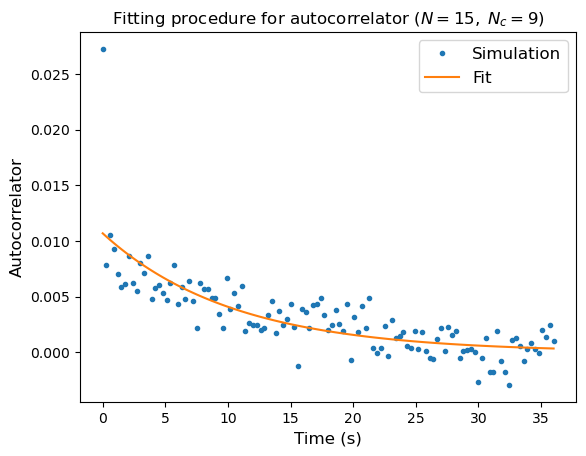

In [122]:
# set parameters
n_steps = 200
tf = 60
n_samples = 250

# receptor parameters
N = 15
Nc = 9

# obtain activities
all_act, time = activity_finder(n_steps,tf,n_samples,N,Nc)

# set cut-off
co = 80

# compute autocorrelator
auto_corr, time_s = autocorr(all_act,time,co)

# perform fitting
popt_nadj, pcov_nadj = curve_fit(noise_fit,time_s,auto_corr)

print('Parameters of best fit: [sigma, tau_n] =', popt_nadj)
print('Standard deviations:', [np.sqrt(pcov_nadj[i,i]) for i in range(2)])

# show results
plt.plot(time_s,auto_corr,'.',label='Simulation')
plt.plot(time_s,noise_fit(time_s,*popt_nadj),label='Fit')
plt.xlabel('Time (s)',size=12)
plt.ylabel('Autocorrelator',size=12)
plt.title(r'Fitting procedure for autocorrelator ($N=15, \; N_c = 9$)')
plt.legend(fontsize=12)
plt.show()

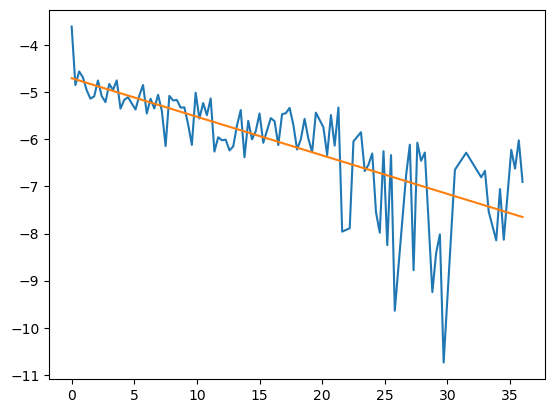

In [127]:
# try log-transforming the data and then fitting

log_data = np.log(auto_corr[auto_corr > 0])

def lin_fit(time,a,b):
    return a + b*time

popt_lin, pcov_lin = curve_fit(lin_fit,time_s[auto_corr > 0],log_data)

# show as desired variables
sigma_n = np.exp(0.5*popt_lin[0])
tau_n = -1/popt_lin[1]

plt.plot(time_s[auto_corr > 0],log_data)
plt.plot(time_s,lin_fit(time_s,*popt_lin))
plt.show()

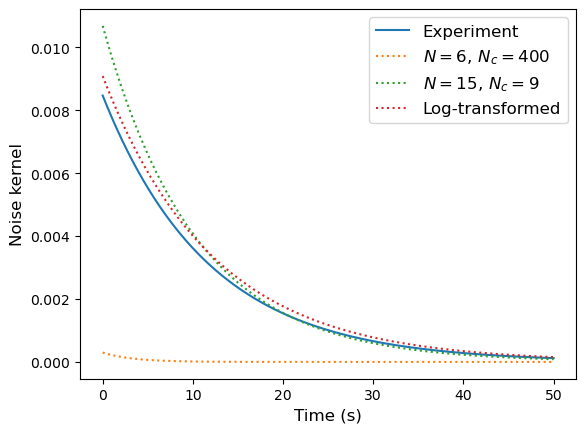

In [129]:
# show the experimental and fitted results in one plot
t_grid = np.linspace(0,50,10**3)

plt.plot(t_grid,noise_fit(t_grid,0.092,11.75),label='Experiment')
plt.plot(t_grid,noise_fit(t_grid,*popt_nlit),':',label=r'$N=6,\, N_c = 400$')
plt.plot(t_grid,noise_fit(t_grid,*popt_nadj),':',label=r'$N=15,\, N_c = 9$')
plt.plot(t_grid,noise_fit(t_grid,sigma_n,tau_n),':',label='Log-transformed')

plt.xlabel('Time (s)',size=12)
plt.ylabel('Noise kernel',size=12)
plt.legend(fontsize=12)

plt.show()